In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV


import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all cvisualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'


In [12]:
df = pd.read_csv("../data/infosys/infosys_data_indicators.csv")
df.head()

Date  Open Price        High         Low  Close Price  \
0  2020-01-01  735.000000  740.000000  732.549988   736.849976   
1  2020-01-02  738.900024  740.799988  730.900024   734.700012   
2  2020-01-03  733.900024  748.000000  733.900024   746.000000   
3  2020-01-06  746.099976  753.799988  736.500000   738.849976   
4  2020-01-07  738.000000  742.599976  725.099976   727.900024   

   Total Traded Quantity         SMA       EWMA5  MiddleBand   UpperBand  \
0              2112415.0  733.360010  733.763936  733.360010  740.403566   
1              5658200.0  734.510010  734.075961  734.510010  739.544561   
2              7882938.0  736.320007  738.050641  736.320007  747.940357   
3              6519403.0  737.509998  738.317086  737.509998  748.585041   
4              7899363.0  736.859998  734.844732  736.859998  749.991883   

    LowerBand        RSI        MFI    ForceIndex        ATR          EMV  
0  726.316453  75.091486  60.432994  1.204066e+07   9.875000   735.609900  
1  729.475458  50.914447  63.893429 -1.216493e+07   8.674988   787.202128  
2  724.699658  88.804649  63.069309  8.907710e+07  11.999970   418.932061  
3  726.434954  44.922051  63.548069 -4.661389e+07  15.699982  1013.368268  
4  723.728112  17.872089  53.158721 -8.649765e+07  17.399994  -694.428360

In [13]:
df.dropna(inplace=True)

In [14]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

In [15]:
# drop_cols = ['Symbol', 'Total Traded Quantity', 'Open Price', 'High',"Average Trading Price",'52 Week Low','52 Week High','MiddleBand','LowerBand','UpperBand']
temp = df
# drop_cols = ['Symbol', 'Total Traded Quantity', 'Open Price', 'Low', 'High',"Average Trading Price",'MiddleBand','LowerBand','UpperBand','Date']
# drop_cols = ['Low']
drop_cols=["Open Price","High","MiddleBand","UpperBand","LowerBand","Date","Low"]

train_df = train_df.drop(columns=drop_cols)
valid_df = valid_df.drop(columns=drop_cols)
test_df  = test_df.drop(columns=drop_cols)

In [16]:
train_df.head()# drop_cols = ['Symbol', 'Total Traded Quantity', 'Open Price', 'High',"Average Trading Price",'52 Week Low','52 Week High','MiddleBand','LowerBand','UpperBand']
# temp = df
# # drop_cols = ['Symbol', 'Total Traded Quantity', 'Open Price', 'Low', 'High',"Average Trading Price",'MiddleBand','LowerBand','UpperBand','Date']
# # drop_cols = ['Low']
# drop_cols=["Open Price","High","MiddleBand","UpperBand","LowerBand","Date","Low"]

# train_df = train_df.drop(columns=drop_cols)
# valid_df = valid_df.drop(columns=drop_cols)
# test_df  = test_df.drop(columns=drop_cols)

Close Price  Total Traded Quantity         SMA       EWMA5        RSI  \
0   736.849976              2112415.0  733.360010  733.763936  75.091486   
1   734.700012              5658200.0  734.510010  734.075961  50.914447   
2   746.000000              7882938.0  736.320007  738.050641  88.804649   
3   738.849976              6519403.0  737.509998  738.317086  44.922051   
4   727.900024              7899363.0  736.859998  734.844732  17.872089   

         MFI    ForceIndex        ATR          EMV  
0  60.432994  1.204066e+07   9.875000   735.609900  
1  63.893429 -1.216493e+07   8.674988   787.202128  
2  63.069309  8.907710e+07  11.999970   418.932061  
3  63.548069 -4.661389e+07  15.699982  1013.368268  
4  53.158721 -8.649765e+07  17.399994  -694.428360

In [17]:

cols = ["Close Price"]
y_train = train_df['Close Price'].copy()
X_train = train_df.drop(columns=cols)

y_valid = valid_df['Close Price'].copy()
X_valid = valid_df.drop(columns=cols)

y_test  = test_df['Close Price'].copy()
X_test  = test_df.drop(columns=cols)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290 entries, 0 to 303
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Total Traded Quantity  290 non-null    float64
 1   SMA                    290 non-null    float64
 2   EWMA5                  290 non-null    float64
 3   RSI                    290 non-null    float64
 4   MFI                    290 non-null    float64
 5   ForceIndex             290 non-null    float64
 6   ATR                    290 non-null    float64
 7   EMV                    290 non-null    float64
dtypes: float64(8)
memory usage: 20.4 KB


In [18]:
# TODO: FIX THE WARNINGS

parameters = {
    'n_estimators': [100,200,500,800],#500
    'learning_rate': [0.001, 0.005, 0.01, 0.05] ,#0.05
    'max_depth': [8, 10, 12, 15,20,32], #8
    'gamma': [0.001, 0.005, 0.01, 0.02],#0.001
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False,random_state=42,silent=True)
clf = GridSearchCV(model, parameters,verbose=False)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')


[14:54:58] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[14:54:58] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[14:54:58] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[14:54:58] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[14:54:58] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[14:54:59] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[14:54:59] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[14:54:59] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[14:54:59] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[14:54:59] WARNING: ../src/learner.cc

In [24]:
parameters = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 8,
    # 'gamma':0.001,
    'random_state': 42
}

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.001, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

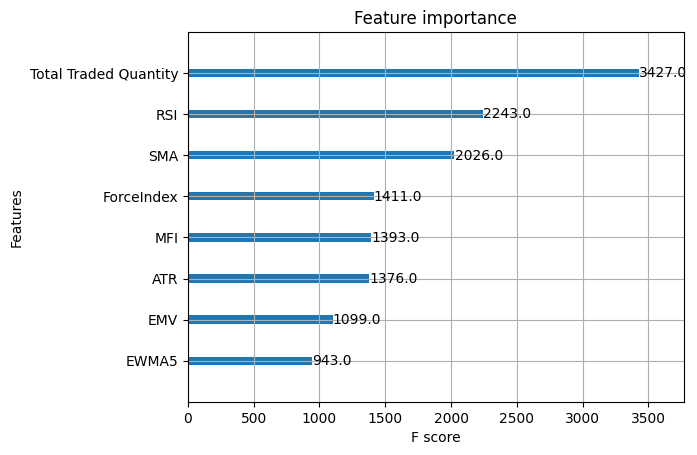

In [25]:
plot_importance(model)

In [26]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')


y_true = [1574.199951 1571.800049 1563.050049 1580.800049 1560.400024]
y_pred = [1384.8918 1378.7173 1354.7252 1363.3447 1352.9858]


In [27]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 100951.00903052803


In [28]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close Price'] = y_pred
predicted_prices.head()

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=temp.index, y=df['Close Price'],
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=y_pred,
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()